### Fashion NMIST classification

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
!pip install tensorflow
!pip install -q -U keras-tuner

In [3]:

# Import Numerical Libraries
import pandas as pd
import numpy as np
import random
from collections import Counter

# Import plotting libraries
import matplotlib.pyplot as plt

# Import keras
import tensorflow as tf
import keras_tuner as kt

from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
#from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner import HyperModel
#from keras_tuner import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import layers

2023-12-18 14:35:33.324025: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 14:35:33.421528: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 14:35:33.421569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 14:35:33.423841: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 14:35:33.439246: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 14:35:33.440783: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Load the Fashion MNIST training, testing and validation tuples

In [4]:
# Load the Fashion MNIST data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()


In [5]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


### Review the images that are part of the data

In [6]:
# Select a random in to indicate an image in the dataset
random_img = random.randint(0, X_train.shape[0] - 21)
random_img

22830

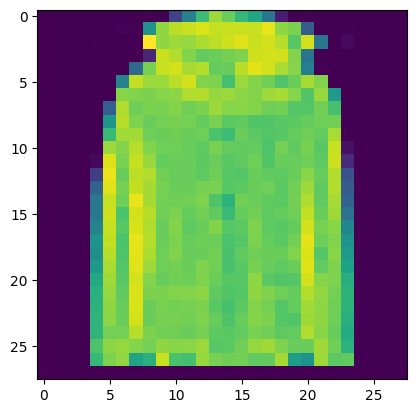

In [7]:
# View the image associated with the random integer
plt.imshow(X_train[random_img])

In [8]:
# View the label for the image above
y_train[random_img]

4

In [9]:
# Look at the distribution of the labels in the training dataset
y_train_value_counts = Counter(y_train)
print(y_train_value_counts)

Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})


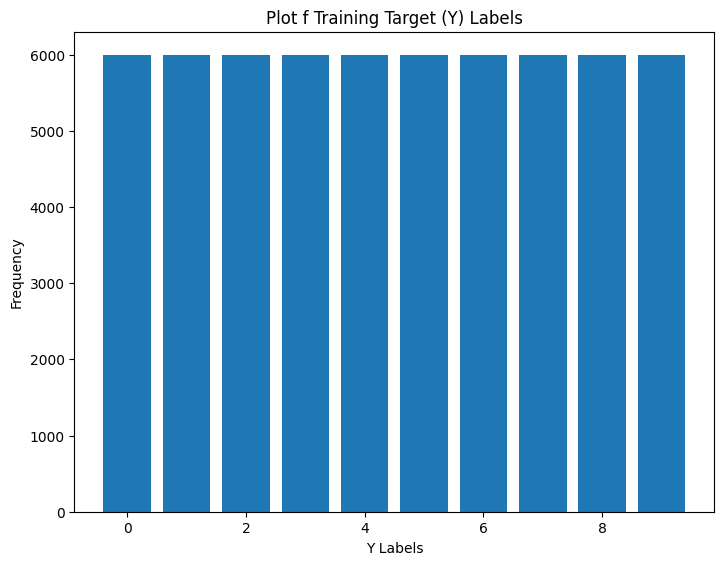

In [10]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(list(y_train_value_counts.keys()),list(y_train_value_counts.values()))
plt.xlabel('Y Labels')
plt.ylabel('Frequency')
plt.title('Plot f Training Target (Y) Labels')
plt.show()

Looks like the values are relative uniform

In [11]:
# The results from the target value is from 0 to 9, but according the Fashion MNIST dataset, the numeric values correspond to fashion items
item = {0: '0: T-shirt/top', 1: '1: Pant', 2: '2: Pullover', 3: '3: Dress', 4: '4: Coat',
        5: '5: Sandal', 6: '6: Shirt', 7: '7: Sneaker', 8: '8: Bag', 9: '10: Ankle boot'}

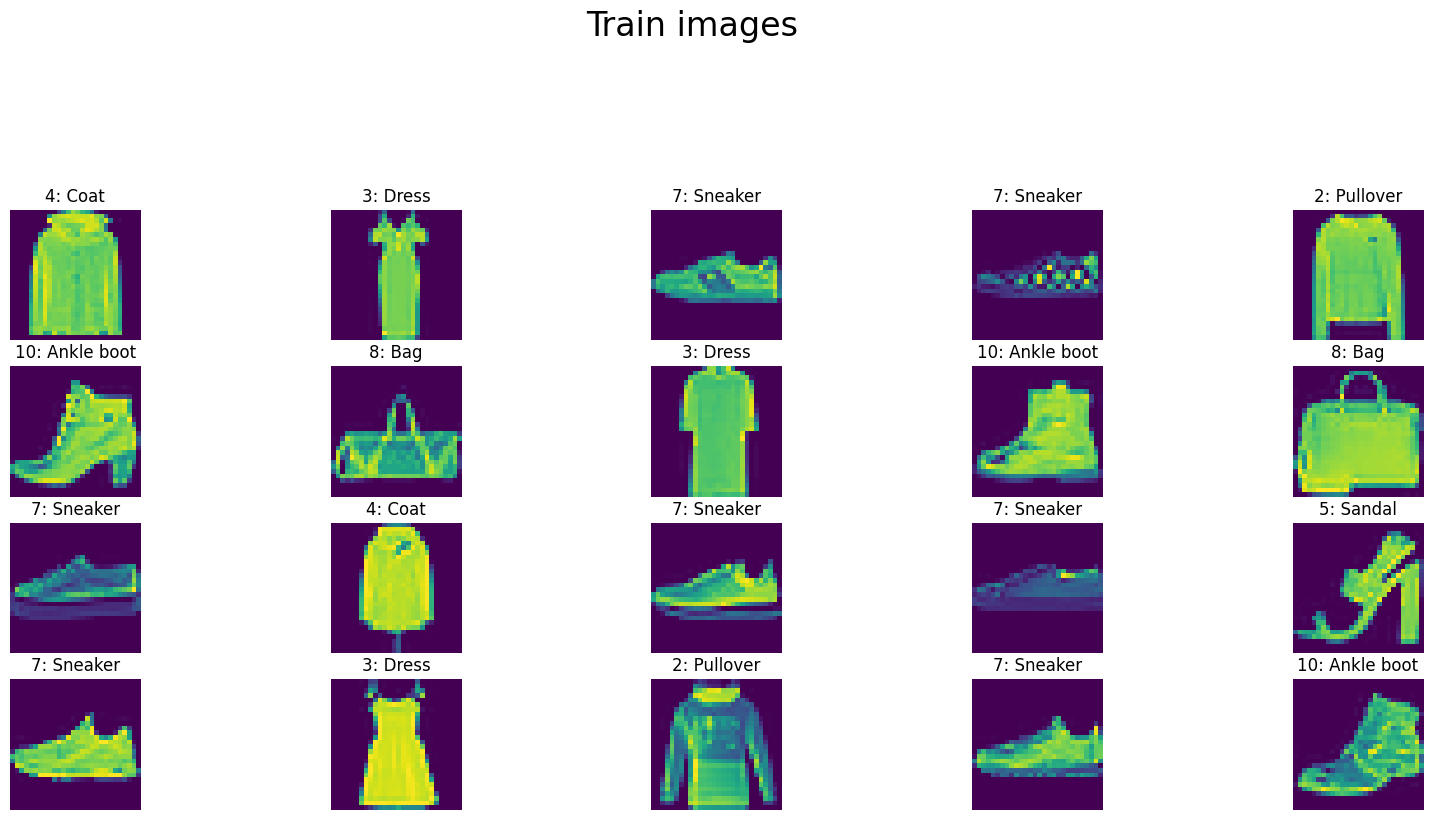

In [12]:
# Select 20 images in the training set to display with the first image being the one above
fig, ax = plt.subplots(figsize=(20, 20))
images = np.array(X_train)

num_images=range(random_img,random_img + 20)
for i in num_images:
    plt.subplot(10, 5, i-random_img+1)
    plt.title(item[y_train[i]])
    img = images[i].reshape(28, 28)
    fig.suptitle('Train images', fontsize=24)
    plt.axis('off')
    plt.imshow(img)

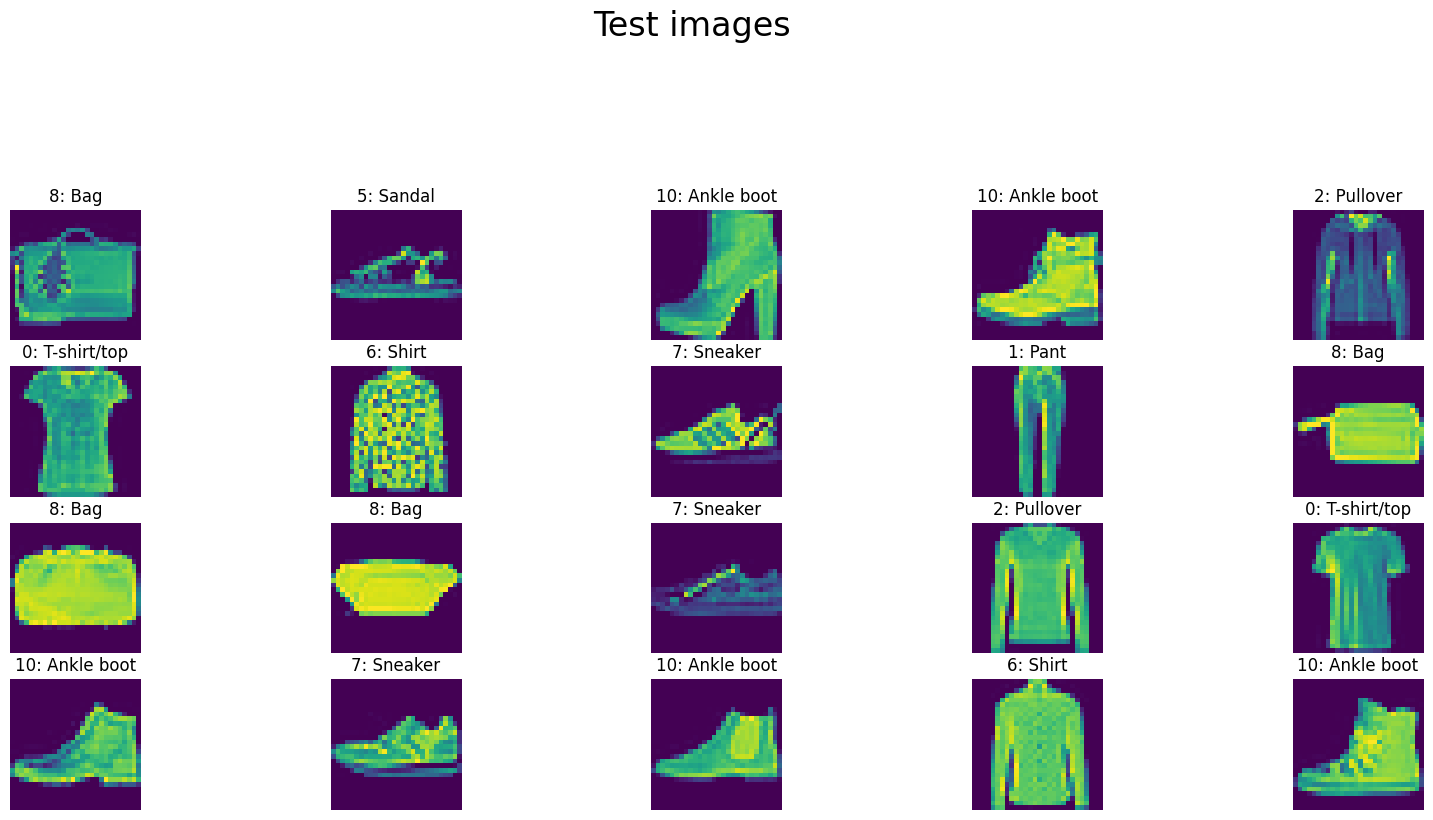

In [13]:
# Select 20 images in the testing set to display
random_test = random.randint(0, X_test.shape[0] - 21)
fig, ax = plt.subplots(figsize=(20, 20))
images = np.array(X_test)

num_images=range(random_test,random_test + 20)
for i in num_images:
    plt.subplot(10, 5, i-random_test+1)
    plt.title(item[y_test[i]])
    img = images[i].reshape(28, 28)
    fig.suptitle('Test images', fontsize=24)
    plt.axis('off')
    plt.imshow(img)

# Preprocessing data via scaling and reshaping

In [14]:
# Reshape and Normalize the data
train_shape, test_shape, img_dim_l, img_dim_w  = X_train.shape[0], X_test.shape[0], X_train.shape[1], X_train.shape[2]
X_train = X_train.reshape(train_shape, img_dim_l, img_dim_w, 1).astype("float32") / 255
X_test = X_test.reshape(test_shape, img_dim_l, img_dim_w, 1).astype("float32") / 255

In [15]:
X_train.shape

(60000, 28, 28, 1)

### Tuning the model using Keras-Tuner

In [16]:
def model_builder(hp):
  '''
  Builds the model and sets up the hyperparameters to tune.

  Args:
    hp - Keras tuner object

  Returns:
    model with hyperparameters to tune
  '''
  
  # Initialize the Sequential API and start stacking the layers
  model = keras.Sequential()
  #model.add(keras.layers.Flatten(input_shape=(28, 28)))
  # Add first convolutional layer and tune the number of filters and kernel size
  model.add(keras.layers.Conv2D(
      filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
      kernel_size=hp.Choice('conv_1_kernel', values=[3,5]), 
      activation='relu',
      input_shape = (28,28,1)
  ))

  # Add a second convolutional layer and tune the number of filters and kernel size
  model.add(keras.layers.Conv2D(
      filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
      kernel_size=hp.Choice('conv_2_kernel', values=[3,5]), activation='relu'))
      
  model.add(keras.layers.Flatten())

  # Add a dense layer and tune the number of filters from 32 to 128
  # Choose an optimal value between 32-512
 
  model.add(keras.layers.Dense(
      units=hp.Int('dense_1_units', min_value=32, max_value=512, step=32), 
      activation='relu')
           )



  # Add the final layer
  model.add(keras.layers.Dense(10, activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

  return model

Lets instantiate it

In [17]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='kt_dir',
                     project_name='kt_hyperband')

Reloading Tuner from kt_dir/kt_hyperband/tuner0.json


In [18]:
# Display hypertuning settings
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [19]:
# To save time, adding a early stopping option if we doen't see significant improvement
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [20]:
epochs=10
# Perform hypertuning
tuner.search(X_train, y_train, epochs=epochs, validation_split=0.2, callbacks=[stop_early])

In [21]:
best_results = tuner.get_best_hyperparameters()[0]


In [30]:
print(f" For the first convolutional layer, the optimal number of filters is {best_results.get('conv_1_filter')} and the optimal kernal size is {best_results.get('conv_1_kernel')}.")
print(f" For the second convolutional layer, the optimal number of filters is {best_results.get('conv_2_filter')} and the optimal kernal size is {best_results.get('conv_2_kernel')}.")
print(f" For the first Dense layer, the optimal number of units is {best_results.get('dense_1_units')}.")
print(f" The optimal learning rate for the optimizer is {best_results.get('learning_rate')}.")

 For the first convolutional layer, the optimal number of filters is 32 and the optimal kernal size is 3.
 For the second convolutional layer, the optimal number of filters is 32 and the optimal kernal size is 3.
 For the first Dense layer, the optimal number of units is 32.
 The optimal learning rate for the optimizer is 0.001.


### Lets build and train the optimal model

In [24]:
optimal_model = tuner.hypermodel.build(best_results)
optimal_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 32)                589856    
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 599754 (2.29 MB)
Trainable params: 599754 (2.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
optimal_model.fit(X_train, y_train, epochs=epochs, validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 76s 50ms/step - loss: 0.4225 - accuracy: 0.8509 - val_loss: 0.3224 - val_accuracy: 0.8862
Epoch 2/10
1500/1500 [==============================] - 74s 49ms/step - loss: 0.2733 - accuracy: 0.9021 - val_loss: 0.2865 - val_accuracy: 0.8954
Epoch 3/10
1500/1500 [==============================] - 76s 51ms/step - loss: 0.2217 - accuracy: 0.9191 - val_loss: 0.2690 - val_accuracy: 0.9042
Epoch 4/10
1500/1500 [==============================] - 73s 49ms/step - loss: 0.1802 - accuracy: 0.9339 - val_loss: 0.2746 - val_accuracy: 0.9040
Epoch 5/10
1500/1500 [==============================] - 73s 49ms/step - loss: 0.1419 - accuracy: 0.9486 - val_loss: 0.2904 - val_accuracy: 0.9074
Epoch 6/10
1500/1500 [==============================] - 73s 49ms/step - loss: 0.1110 - accuracy: 0.9589 - val_loss: 0.2995 - val_accuracy: 0.9082
Epoch 7/10
1500/1500 [==============================] - 75s 50ms/step - loss: 0.0864 - accuracy: 0.9690 - val_loss: 0.3490 -

In [26]:
optimal_eval_dict = optimal_model.evaluate(X_test, y_test, return_dict=False)

313/313 [==============================] - 4s 12ms/step - loss: 0.4343 - accuracy: 0.9077


In [27]:
from sklearn.metrics import classification_report

In [28]:
predicted = optimal_model.predict(X_test)

313/313 [==============================] - 4s 12ms/step


In [29]:
print('Classification Report')
predicted

Classification Report


array([[4.63893012e-17, 2.31613156e-20, 2.00670600e-12, ...,
        1.94045331e-08, 1.69966174e-16, 9.99999940e-01],
       [1.61561459e-07, 1.12138880e-20, 9.99999821e-01, ...,
        1.29238570e-20, 8.89541300e-29, 3.19823858e-17],
       [6.58110014e-13, 9.99999940e-01, 1.06080068e-24, ...,
        4.42312770e-22, 1.22905065e-14, 1.76474482e-27],
       ...,
       [2.01125921e-11, 5.68579535e-17, 8.42413854e-08, ...,
        4.32619164e-14, 9.99999821e-01, 2.55209645e-13],
       [5.80391029e-18, 9.99999940e-01, 1.50241344e-32, ...,
        2.00735818e-22, 1.40800980e-17, 8.39041762e-30],
       [2.21717666e-09, 1.66366758e-12, 8.08140488e-09, ...,
        5.11749131e-05, 9.03500620e-07, 6.55345644e-08]], dtype=float32)

In [31]:
label = item[np.argmax(predicted)]

In [32]:
label

'10: Ankle boot'